In [1]:
import CTBGame as CTB
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class ReplayMem:
    def __init__(self,memoryslots):
        self.memoryslots=memoryslots
        self.memory=[]
    def Add(self, state, predict, gameover):
        self.memory.append([state, predict, gameover])
        if(len(self.memory)>self.memoryslots):
            del self.memory[0]
    def retrieve(self):
        return self.memory
    def getbatch(self,size):
        states=[]
        predicts=[]
        
        if(size>len(self.memory)):
            size=len(self.memory)
        batch=random.sample(self.memory,size)
        
        for entry in batch:
            tstate,tpredict,tgameover = entry
            states.append(tstate)
            predicts.append(tpredict)
            
        return states,predicts
        

In [3]:
def Policy(movearray, availmoves, epsilon):
    available_moves = []
    for move in availmoves:
        available_moves.append(movearray[0][move])
    number_of_moves = len(available_moves)
    if epsilon > random.uniform(0,1):
        choice_index = random.randint(0,(number_of_moves-1))
    else:
        choice_index = np.argmax(available_moves)
    choice = availmoves[choice_index]
    return choice

# Neural net will have 11 inputs and 36 outputs
### Inputs are [1,2,3,4,5,6,7,8,9,dice]
### Outputs are [0,1]...[5,6]

In [7]:
model = keras.Sequential()
model.add(keras.layers.Dense(22, input_dim=11, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(36, activation='linear'))
model.compile(loss='mse', optimizer='sgd', metrics=['mae'])
print(model.input_shape)

(None, 11)


In [8]:
def TestWinRate(numtests,model,game):
    wins=0
    for x in range(0,numtests):
        game_over=False
        game=CTB.Game(1,1,1,1,1,1,1,1,1)
        game.startturn()
        while not game_over:
            state = game.showenv_vect()
            state = state.reshape(1,11)
            moves = game.showmoves()
            prediction = model.predict(state)
            action = Policy(prediction,moves,epsilon)

            game.makemove(action)
            game.startturn()
            game_over = game.gameover()
            if(game.iwon()):
                wins = wins+1
        #if (x % (numtests/10)==0):
            #print ("tick")
            #print(wins)
    #print("done")
    return(wins/numtests)

In [9]:
numgenerations = 100
numepochs = 1500
numtests = 3000
epsilon = 0.9
epsilon_degrade = 0.99994
discount = 0.95
results=[]
completedepochs=0

for y in range(0,numgenerations):
    winpercent = 0
    for x in range(0,numepochs):
        completedepochs = completedepochs+1
        game_over=False
        game=CTB.Game(1,1,1,1,1,1,1,1,1)
        game.startturn()

        epsilon = epsilon * epsilon_degrade
        while not game_over:
            state = game.showenv_vect()
            state = state.reshape(1,11)
            moves = game.showmoves()
            prediction = model.predict(state,verbose=0)
            action = Policy(prediction,moves,epsilon)

            game.makemove(action)
            game.startturn()
            new_state = game.showenv_vect()
            new_state = new_state.reshape(1,11)
            game_over = game.gameover()

            r = (game.getscore())
            if not game_over:
                max_next_r = (np.max(model.predict(new_state,verbose=0)))
                r = r + (discount * max_next_r)
            else:
                if(game.iwon()):
                    r = 5

            corrected_prediction = prediction
            corrected_prediction[0][action] = r
            model.fit(state,corrected_prediction,verbose=0)
    winpercent = TestWinRate(numtests,model,game)
    print(winpercent)
    print(epsilon)
    results.append([completedepochs,winpercent,epsilon])
    if(winpercent>0.055):
        break;


0.029
0.8225358458055481
0.023333333333333334
0.7517391307056098
0.033
0.6870359796667409
0.025333333333333333
0.6279019118155861
0.025
0.5738575890201706
0.033
0.5244649303962647
0.03
0.4793235612431535
0.030666666666666665
0.4380675676240706
0.03133333333333333
0.4003625302840499
0.032
0.3659028138622684
0.030666666666666665
0.3344090894253685
0.029
0.30562607023951033
0.03233333333333333
0.27932044242742415
0.041
0.25527897373646874
0.035
0.23330678508744265
0.03933333333333333
0.21322577089341432
0.035
0.19487315534372707
0.030333333333333334
0.17810017295049863
0.03266666666666666
0.1627708626621696
0.036333333333333336
0.14876096576925146
0.03166666666666667
0.13595691866873444
0.044
0.12425493232255967
0.033666666666666664
0.1135601509482752
0.037
0.10378588312227252
0.03766666666666667
0.09485289906294907
0.037333333333333336
0.08668878839761246
0.03933333333333333
0.07922737320720935
0.042333333333333334
0.07240817159104863
0.03833333333333333
0.06617590740319612
0.03666666666

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.048
0.011968343928300115
0.044
0.010938213217728933
0.04133333333333333
0.009996747178495656
0.04533333333333334
0.00913631432863126
0.047
0.008349940037606739
0.046
0.0076312499902871905
0.052333333333333336
0.006974418517016053
0.05466666666666667
0.006374121370995199
0.04833333333333333
0.005825492570176393
0.047
0.00532408495382665
0.051333333333333335
0.00486583413404044
0.052333333333333336
0.004447025549991625
0.051
0.004064264357868052
0.051333333333333335
0.003714447912418168
0.051333333333333335
0.003394740617046142
0.04666666666666667
0.003102550938591663
0.048666666666666664
0.0028355104004769895
0.051666666666666666
0.002591454383940848
0.052
0.0023684045817347565
0.050666666666666665
0.002164552962052151
0.050333333333333334
0.0019782471127027385
0.047
0.0018079768467325868
0.046
0.0016523619609155934
0.050666666666666665
0.0015101410478873614
0.052
0.0013801612712330083
0.04766666666666667
0.0012613690206463352
0.052333333333333336
0.0011528013714113886
0.0506666666666

# Now that we've trained the AI for awhile, lets see how it does statistically!

In [59]:
numtests=100
wins=0

for x in range(0,numtests):
    game_over=False
    game=CTB.Game(1,1,1,1,1,1,1,1,1)
    game.startturn()
    while not game_over:
        state = game.showenv_vect()
        state = state.reshape(1,11)
        moves = game.showmoves()
        prediction = model.predict(state)
        action = Policy(prediction,moves,epsilon)

        game.makemove(action)
        game.startturn()
        game_over = game.gameover()
        if(game.iwon()):
            wins = wins+1
    if (x % (numtests/10)==0):
        print ("tick")
        print(wins)
print("done")
print(wins/numtests)

tick
0
tick
1
tick
2
tick
4
tick
4
tick
4
tick
4
tick
4
tick
5
tick
5
done
0.07


Text(0, 0.5, 'Win Rate')

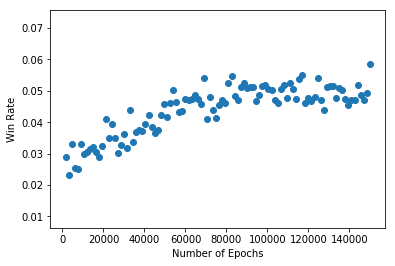

In [12]:
result_epoch = [element[0] for element in results]
result_wins = [element[1] for element in results]
result_epsilon = [element[2] for element in results]
plt.scatter(result_epoch, result_wins)
plt.xlabel("Number of Epochs")
plt.ylabel("Win Rate")

#plt.scatter(result_epoch,result_epsilon)

In [11]:
results[0]

[1000, 0.0272, 0.8143496042026991]

In [74]:
model.save_weights("model.h5")

# Compare difference in Optimal Play and trained NN

This code is going to be terrible but bear with me

In [61]:
from OptimalPlayStrat import Strat

Setup basic functions for dealing with the Optimal Play strategy

In [62]:
def GameStatetoIndex(gamestate,strat):
    for index in range(0,len(strat)):
        if(gamestate==strat[index][0:10]):
            return index

def StratIndextoBestMove(index,strat):
    movearray=strat[index][10]
    if (len(movearray)==0):#If there are no possible moves
        return []
    bestmove=[0,0]
    for move in movearray:
        [moveindex,move_success_chance]=move
        [bestmoveindex,bestmove_success_chance]=bestmove
        if move_success_chance >= bestmove_success_chance:
            bestmove=move
    return bestmove
moveArray=[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],
                        [1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8],[1,9],
                        [2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[2,9],
                        [3,4],[3,5],[3,6],[3,7],[3,8],[3,9],
                        [4,5],[4,6],[4,7],[4,8],
                        [5,6],[5,7]]

In [71]:
Differences=[]

for gamestate in Strat:
    gs=gamestate
    testGame = CTB.Game(gs[0],gs[1],gs[2],gs[3],gs[4],gs[5],gs[6],gs[7],gs[8])
    dice = gs[9]
    testGame.startturn()
    
    testGame.startturn_cheat(dice)
    state = testGame.showenv_vect()
    state[10] = dice/12
    state = state.reshape(1,11)
    
    
    prediction = model.predict(state)
    moves = testGame.showmoves()
    if len(moves)==0: #Don't compute further if game is over
        continue
    NNaction = Policy(prediction,moves,epsilon)
    
    stateIndex = GameStatetoIndex(gamestate[0:10],Strat)
    Strataction = StratIndextoBestMove(stateIndex,Strat)
    
    if not(moveArray[NNaction]==moveArray[Strataction[0]]):
        difState = gamestate[0:10]+[moveArray[NNaction]]+[moveArray[Strataction[0]]]
        Differences.append(difState)
print(len(Differences))
print(len(Strat))
    


222
5632


In [72]:
print(Differences[0:10])

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 6, [0, 6], [1, 5]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 7, [0, 7], [1, 6]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 8, [0, 8], [3, 5]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 9, [0, 9], [4, 5]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 10, [1, 9], [4, 6]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 11, [2, 9], [5, 6]], [1, 1, 1, 1, 1, 1, 1, 1, 1, 12, [3, 9], [5, 7]], [0, 1, 1, 1, 1, 1, 1, 1, 1, 11, [2, 9], [5, 6]], [0, 1, 1, 1, 1, 1, 1, 1, 1, 12, [3, 9], [5, 7]], [1, 0, 1, 1, 1, 1, 1, 1, 1, 8, [0, 8], [1, 7]]]


In [73]:
with open("StratDifferences.py", 'w') as file_handler:
        file_handler.write("Strat={}\n".format(Differences))